# Segmentation 

In [90]:
# import statements 
import numpy as np
import matplotlib.pyplot as plt 
from skimage.transform import resize
from scipy.signal import convolve2d


## Gray Images

In [91]:
def anti_aliasing_resize(img):
    """This function can be used for resizing images of huge size to optimize the segmentation algorithm"""
    ratio = min(1, np.sqrt((512*512) / np.prod(img.shape[:2])))
    newshape = list(map( lambda d : int(round(d*ratio)), img.shape[:2])) 
    img = resize( img, newshape , anti_aliasing = True )
    return img

def convert_to_grayscale(image):
    if len(image.shape) == 3: 
        return  np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
    return image

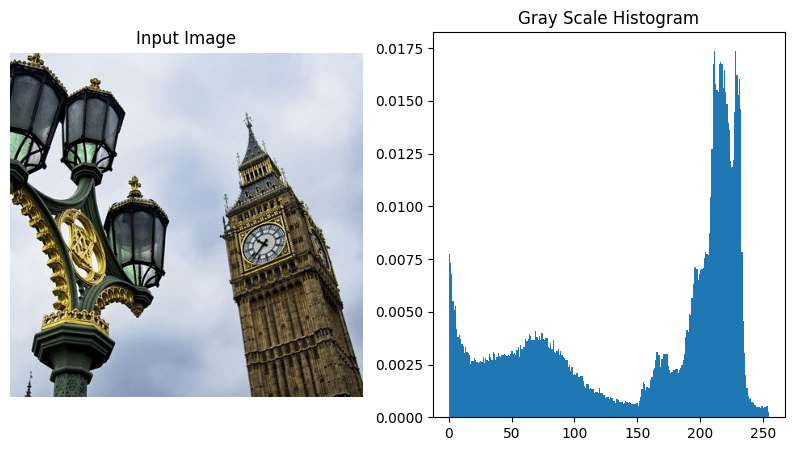

In [92]:
fig_1, ax_1 = plt.subplots(1,2,figsize = (10,5))
test_image_1 = plt.imread("Elizabeth_Tower_London.jpg")
ax_1[0].imshow(test_image_1)
ax_1[0].axis("off");
ax_1[0].set_title("Input Image")
ax_1[1].hist(convert_to_grayscale(test_image_1).flatten(), 256, density = True);
ax_1[1].set_title("Gray Scale Histogram");

### Optimal Thresholding

In [93]:
def optimal_th(image):
    bg_sum = image[0,0] + image[-1,0] + image[-1,-1] + image[0,-1]  # first assumption, the background is the corners. 
    fg_sum = np.sum(np.sum(image, axis=0)) - bg_sum
    bg_mean = bg_sum / 4 
    fg_mean = fg_sum / (np.size(image) - 4) # size returns the entire number of pixles 
    th_prev = (bg_mean + fg_mean) / 2 
    while True:
        bg_mean = np.mean(image[image < th_prev])
        fg_mean = np.mean(image[image >= th_prev]) 
        curr_th =  (bg_mean + fg_mean) / 2 
        if curr_th == th_prev: # convergence 
            return curr_th
        else: # otherwise update and keep going. 
            th_prev = curr_th

In [94]:
gray_scaled_image = convert_to_grayscale(test_image_1)  
th = optimal_th(gray_scaled_image) 

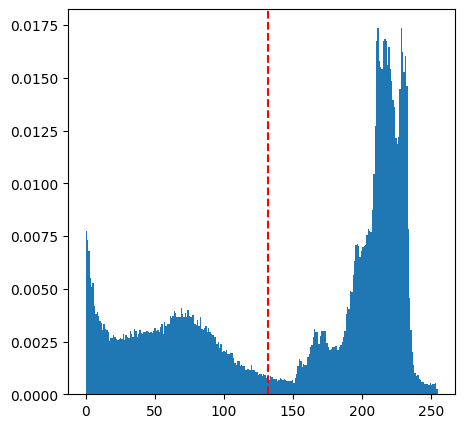

In [95]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
magnitude = ax.hist(gray_scaled_image.flatten(), 256, density = True);
ax.axvline(x=th, color='r', linestyle='--'); # very good seperation 

In [96]:
def apply_optimal_threshodling(image):
    image = convert_to_grayscale(image)
    image = anti_aliasing_resize(image)
    th = optimal_th(image)
    print(th) # fractional not in range (0,255)
    fig, ax = plt.subplots(figsize = (7,7))
    ax.imshow(image >= th, cmap="gray")
    ax.axis("off")

132.01704517695765


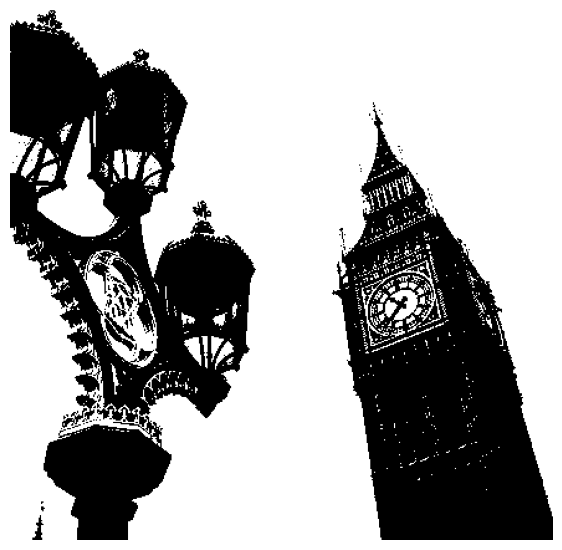

In [97]:
apply_optimal_threshodling(test_image_1)

### Otsu's Thresholding (Using In-between Variance Maximization Criteria)

In [98]:
def otsu_th(image): # takes colored image 
    mapped_image = ((image - image.min())*(1/(image.max() - image.min()))*255).astype(np.uint8) # map up 

    hist_lookup = np.array([np.sum(mapped_image == i) for i in range(256)])  * 1/ np.size(image) 
    in_between_var = (0,-np.inf) # assumption (best_intensity, max_value) 

    for candidate_th in range(256):
        w_0 = np.sum(hist_lookup[:candidate_th]) 
        w_1 = np.sum(hist_lookup[candidate_th:]) 

        if w_0 == 0 or w_1 == 0:
            continue
        
        mu_0 = np.sum(np.array([i * hist_lookup[i] for i in range(0,candidate_th)])) * 1/w_0
        mu_1 = np.sum(np.array([i * hist_lookup[i] for i in range(candidate_th, 256)])) * 1/w_1

        curr_result = w_0 * w_1 * (mu_0 - mu_1) ** 2

        if curr_result > in_between_var[1]:
            in_between_var = (candidate_th,curr_result)

    th = (in_between_var[0]/255)*(image.max()-image.min()) + image.min() # map down 

    return th  


In [99]:
def apply_otsu_threshodling(image):
    image = convert_to_grayscale(image)
    image = anti_aliasing_resize(image)
    th = otsu_th(image)
    print(th) # fractional threshold value. 
    fig, ax = plt.subplots(figsize = (7,7))
    ax.imshow(image >= th, cmap="gray")
    ax.axis("off") 

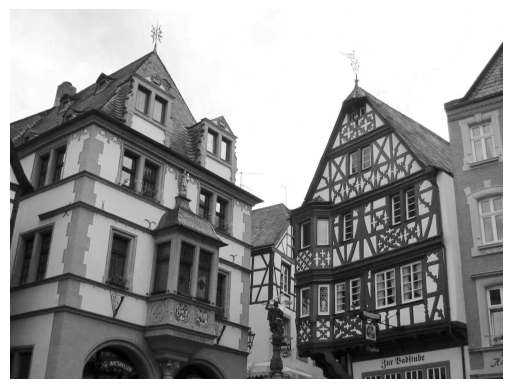

In [100]:
test_image_2 = plt.imread("Image_processing_pre_otsus_algorithm.jpg");
plt.imshow(test_image_2, cmap="gray")
plt.axis("off");

0.6039643145626001


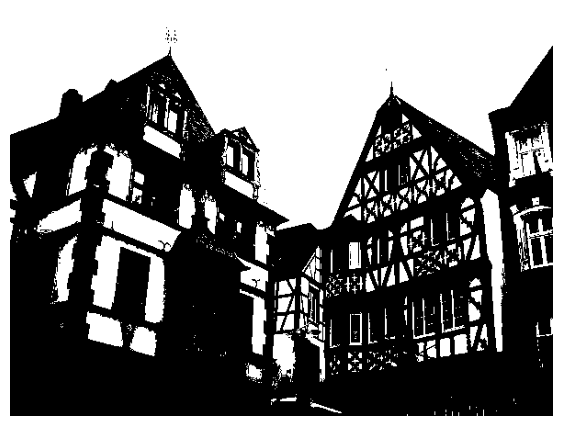

In [101]:
apply_otsu_threshodling(test_image_2);

### Spectral Thresholding (Local and Global)  

In [102]:
def global_thresholding(img):
    img = convert_to_grayscale(img)
    img = anti_aliasing_resize(img)

    threshold = np.mean(img)
    binary_img = (img > threshold) * 255
    fig, ax = plt.subplots(figsize = (7,7))
    ax.imshow(binary_img, cmap="gray")
    ax.axis("off") 


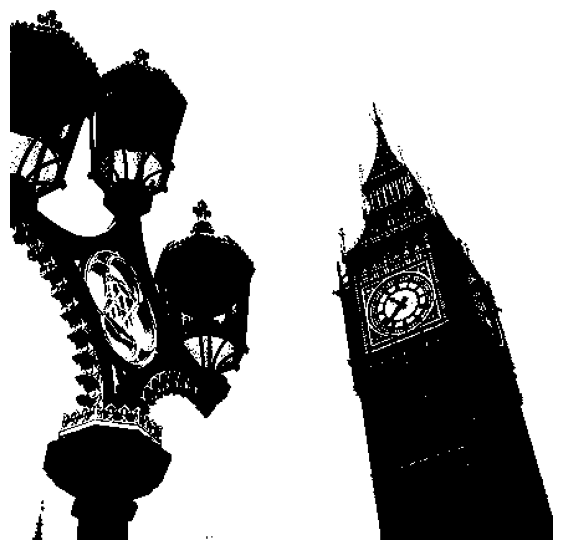

In [103]:
global_thresholding(test_image_1)

In [104]:
def local_thresholding(img, window_size = 15):
    img = convert_to_grayscale(img)
    img = anti_aliasing_resize(img)

    kernel = np.ones((window_size, window_size)) / (window_size ** 2) # averaging kernel 

    mean_img = convolve2d(img, kernel, mode='same') # same size of imput image 
    binary_img = (img > mean_img) * 255

    fig, ax = plt.subplots(figsize = (7,7))
    ax.imshow(binary_img, cmap="gray")
    ax.axis("off") 


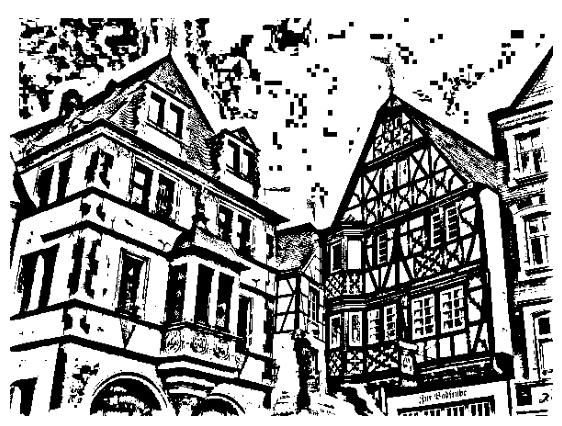

In [105]:
local_thresholding(test_image_2, 20) # window size of 20 

## Colored Images 

### Map RGB to LUV 

RESOURCE : https://framewave.sourceforge.net/Manual/fw_function_020_0060_00330.html

In [106]:
def rgb_to_xyz(rgb):
    """Convert RGB color values to XYZ color values."""
    R, G, B = rgb[..., 0], rgb[..., 1], rgb[..., 2]
    X = 0.412453 * R + 0.35758 * G + 0.180423 * B
    Y = 0.212671 * R + 0.71516 * G + 0.072169 * B
    Z = 0.019334 * R + 0.119193 * G + 0.950227 * B
    return np.stack((X, Y, Z), axis=-1)


- The XYZ color space is a device-independent color space that was defined by the Commission Internationale de l'Eclairage (CIE) in 1931. It's based on human color perception and serves as a foundation for many other color spaces. 

- XYZ does not represent spatial space; instead, it represents colors in a three-dimensional space based on the tristimulus values X, Y, and Z. These values are derived from the spectral response curves of the human eye's cone cells, which are responsible for color vision. 

- The XYZ color space is device-independent, meaning it's not tied to any specific display or imaging system. It's designed to encompass all visible colors under standard viewing conditions. However, XYZ values themselves don't directly correspond to colors as we perceive them. Instead, **they serve as an intermediate step for converting between different color spaces**.

- The conversion from XYZ to other color spaces, such as RGB, LUV, Lab, etc., involves specific mathematical transformations that take into account the characteristics of the target color space and the spectral sensitivities of the human eye. 

- The inverse matrix that transform from XYZ to RGB again looks like this: 
\begin{bmatrix}
3.2406 & -1.5372 & -0.4986 \\
-0.9689 & 1.8758 & 0.0415 \\
0.0557 & -0.2040 & 1.0570 \\
\end{bmatrix}

In [107]:
def xyz_to_luv(xyz):
    X, Y, Z = xyz[..., 0], xyz[..., 1], xyz[..., 2]
    constant = 903.3
    un = 0.19793943
    vn = 0.46832096

    epsilon = 1e-12 # to prevent division by zero
    u_prime = 4 * X / (X + 15 * Y + 3 * Z + epsilon)
    v_prime = 9 * Y / (X + 15 * Y + 3 * Z + epsilon)

    L = np.where(Y > 0.008856, 116 * Y**(1/3) - 16, constant * Y)
    U = 13 * L * (u_prime - un)
    V = 13 * L * (v_prime - vn)

    return  np.stack((L, U, V), axis=-1)


In [108]:
def scale_luv_8_bits(luv_image):
    L, U, V= luv_image[..., 0], luv_image[..., 1], luv_image[..., 2]

    scaled_L = L * (255 / 100)
    scaled_U = (U + 134) * (255 / 354)
    scaled_V = (V + 140) * (255 / 262)

    return np.stack((L, U, V), axis=-1)

In [109]:
def map_rgb_luv(image):
    image = anti_aliasing_resize(image)
    normalized_image = (image - image.min()) / (image.max() - image.min()) # nomalize before 
    xyz_image = rgb_to_xyz(normalized_image)
    luv_image = xyz_to_luv(xyz_image)
    luv_image_normalized = (luv_image - luv_image.min()) / (luv_image.max() - luv_image.min())  # normalize after  (point of question !!)
    # scaled_image = scale_luv_8_bits(luv_image) 
    return luv_image_normalized

In [110]:
luv_image = map_rgb_luv(test_image_1)


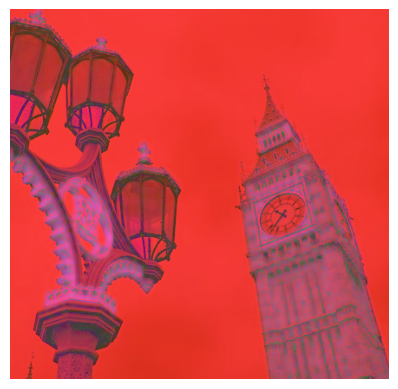

In [111]:
plt.imshow(luv_image)
plt.axis('off')  
plt.show()

### K-Means Clustering

In [112]:
test_image_3 = plt.imread("fresh-organic-vegetables.jpg")
luv_image = map_rgb_luv(test_image_3)


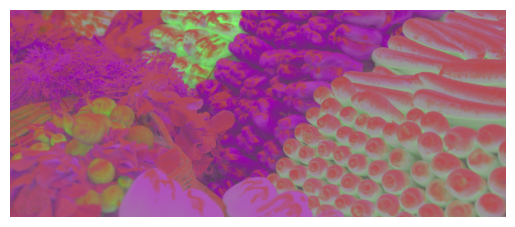

In [113]:
plt.imshow(luv_image)
plt.axis('off')  
plt.show()

In [114]:
def kmeans_segmentation(image, nclusters, max_iterations=4, include_spatial_seg=False, spatial_ratio = 1, centroids_optimization=True, centroids_color=None, centroids_spatial=None):
    """
    Perform K-means clustering segmentation on an input image.

    Parameters:
    - image (numpy.ndarray): Input colored image to be segmented.
    - nclusters (int): Number of clusters (or segments) to divide the image into.
    - max_iterations (int, optional): Maximum number of iterations for the K-means algorithm. Default is 4.
    - include_spatial_seg (bool, optional): Flag indicating whether to include spatial segmentation. Default is False.
    - centroids_optimization (bool, optional): Flag indicating whether to optimize centroids. Default is True.
    - centroids_color (numpy.ndarray, optional): Initial centroids in terms of color. Default is None.
    - centroids_spatial (numpy.ndarray, optional): Initial centroids in terms of spatial coordinates. Default is None.
    - spatial_ratio (float, optional): it specifies the amount of spatial segmentation penalty introduced.

    Returns:
    If include_spatial_seg is False:
    - centroids_color (numpy.ndarray): Final centroids in terms of color.
    - labels (numpy.ndarray): Labels of each pixel indicating which cluster it belongs to.

    If include_spatial_seg is True:
    - centroids_color (numpy.ndarray): Final centroids in terms of color.
    - centroids_spatial (numpy.ndarray): Final centroids in terms of spatial coordinates.
    - labels (numpy.ndarray): Labels of each pixel indicating which cluster it belongs to.
    """
    img = np.array(image, copy=True, dtype=float)

    if include_spatial_seg:
        h, w, _ = img.shape
        x_coords, y_coords = np.meshgrid(np.arange(w), np.arange(h))
        xy_coords = np.column_stack((x_coords.flatten(), y_coords.flatten()))  # spatial coordinates in the features space 

    img_as_features = img.reshape(-1, img.shape[2])  # without spatial info included 

    labels = np.zeros((img_as_features.shape[0], 1))  # (image size x 1) this array contains the labels of each pixel (belongs to which centroid)

    distance = np.zeros((img_as_features.shape[0], nclusters), dtype=float)  # (distance for each colored pixel over the entire clusters)

    # if the centriods have been not provided 
    if centroids_color is None:
        centroids_indices = np.random.choice(img_as_features.shape[0], nclusters, replace=False)  # initialize the centroids 
        centroids_color = img_as_features[centroids_indices]  # in terms of color    
        if include_spatial_seg:
            centroids_spatial = xy_coords[centroids_indices]  # this to introduce restriction in the spatial space of the image 

        # Form initial clustering 
        if centroids_optimization: 
            rows = np.arange(img.shape[0])
            columns = np.arange(img.shape[1])
            
            sample_size = len(rows) // 16 if len(rows) > len(columns) else len(columns) // 16
            ii = np.random.choice(rows, size=sample_size, replace=False)
            jj = np.random.choice(columns, size=sample_size, replace=False)
            subimage = img[ii[:, np.newaxis], jj[np.newaxis, :], :] # subimage for redistribute the centriods 

            if include_spatial_seg: 
                centroids_color, centroids_spatial, _ = kmeans_segmentation(subimage, nclusters, max_iterations//2, centroids_color=centroids_color, centroids_spatial=centroids_spatial, include_spatial_seg=True)
            else:
                centroids_color, _ = kmeans_segmentation(subimage, nclusters, max_iterations//2, centroids_color=centroids_color)



    for _ in range(max_iterations):
        for centroid_idx in range(centroids_color.shape[0]):
            distance[:, centroid_idx] = np.linalg.norm(img_as_features - centroids_color[centroid_idx], axis=1) 

            if include_spatial_seg:
                distance[:, centroid_idx] += np.linalg.norm(xy_coords - centroids_spatial[centroid_idx], axis=1) * spatial_ratio 

        labels = np.argmin(distance, axis=1) # assign each point in the feature space a label according to its distance from each centriod based on (spatial and color distance) 

        for centroid_idx in range(centroids_color.shape[0]):
            cluster_colors = img_as_features[labels == centroid_idx]
            if len(cluster_colors) > 0:  # Check if cluster is not empty
                new_centroid_color = np.mean(cluster_colors, axis=0)
                centroids_color[centroid_idx] = new_centroid_color

                if include_spatial_seg:
                    cluster_spatial = xy_coords[labels == centroid_idx]
                    new_centroid_spatial = np.mean(cluster_spatial, axis=0)
                    centroids_spatial[centroid_idx] = new_centroid_spatial

    if include_spatial_seg:
        return centroids_color, centroids_spatial, labels
    else:
        return centroids_color, labels


#### Expeimenting with K-Means Clustering

In [115]:
# no spatial restriction (non-uniformity)  + optimzation 
centroids,labels = kmeans_segmentation(test_image_3, 10,10,centroids_optimization=False, include_spatial_seg= False)

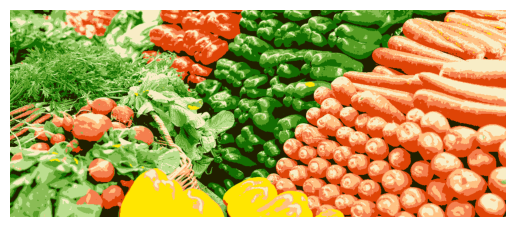

In [116]:
output  = centroids[labels] 
output  = output.reshape(test_image_3.shape)
output = (output - output.min()) / (output.max() - output.min())   
plt.imshow(output)
plt.axis('off')  
plt.show()

----

In [117]:
#  spatial restriction (uniformity) + optimzation 
centroids,_, labels = kmeans_segmentation(test_image_3, 7, 10, centroids_optimization=True, include_spatial_seg= True,  spatial_ratio= 0.5)

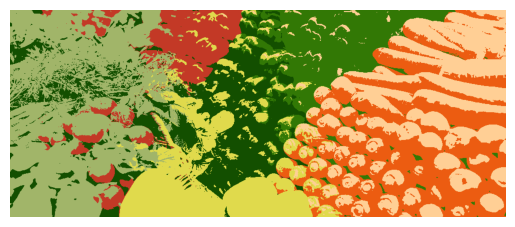

In [118]:
output  = centroids[labels] 
output  = output.reshape(test_image_3.shape)
output = (output - output.min()) / (output.max() - output.min())  
plt.imshow(output)
plt.axis('off')  
plt.show()

----



In [119]:
#  spatial restriction (uniformity) + no optimzation 
centroids,_, labels = kmeans_segmentation(test_image_3, 10, 10, centroids_optimization=False, include_spatial_seg= True, spatial_ratio= 1)

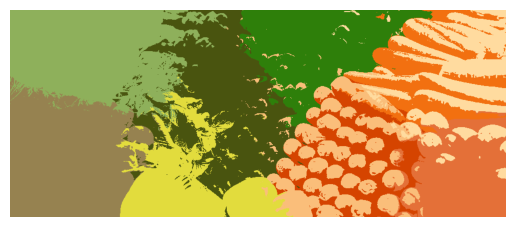

In [120]:
output  = centroids[labels] 
output  = output.reshape(test_image_3.shape)
output = (output - output.min()) / (output.max() - output.min())  
plt.imshow(output)
plt.axis('off')  
plt.show()

----

In [121]:
#  no spatial restriction (uniformity) + no optimzation 
centroids, labels = kmeans_segmentation(test_image_3, 10, 10, centroids_optimization=False, include_spatial_seg= False)

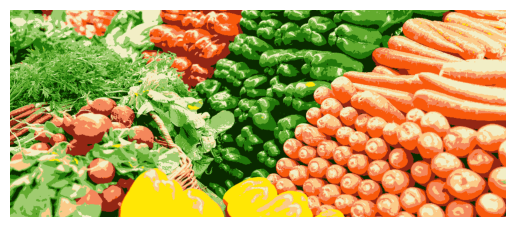

In [122]:
output  = centroids[labels] 
output  = output.reshape(test_image_3.shape)
output = (output - output.min()) / (output.max() - output.min())
plt.imshow(output)
plt.axis('off')  
plt.show()

----

In [139]:
test_image_4 = plt.imread("WhatsApp Image 2024-04-27 at 00.06.17_3ccb6608.jpg")

In [123]:
luv_image = map_rgb_luv(test_image_3)
centroids,labels = kmeans_segmentation(luv_image, 10,10,centroids_optimization=False, include_spatial_seg= False)

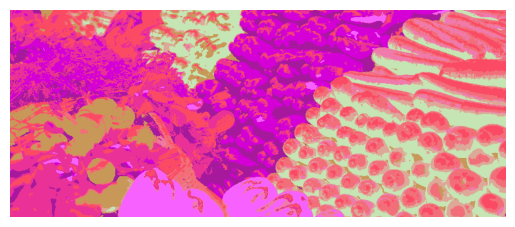

In [124]:
output  = centroids[labels] 
output  = output.reshape(luv_image.shape)
output = (output - output.min()) / (output.max() - output.min())
plt.imshow(output)
plt.axis('off')  
plt.show()

----

In [140]:
luv_image = map_rgb_luv(test_image_4)
centroids,labels = kmeans_segmentation(luv_image, 10,10,centroids_optimization=False, include_spatial_seg= False)

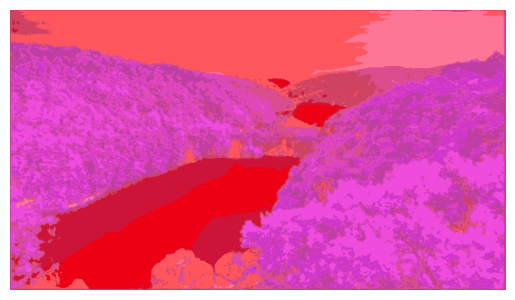

In [141]:
output  = centroids[labels] 
output  = output.reshape(luv_image.shape)
output = (output - output.min()) / (output.max() - output.min())
plt.imshow(output)
plt.axis('off')  
plt.show()

### Mean-Shift 

In [125]:
def gaussian_weight(distance, sigma):
    """Introduce guassian weighting based on the distance from the mean"""
    return np.exp(-(distance**2) / (2 * sigma**2))

In [145]:
def mean_shift_clusters(image, window_size, threshold, sigma):
    """
    Perform Mean Shift clustering on an image.

    Args:
        image (numpy.ndarray): The input image.
        window_size (float): The size of the window for the mean shift.
        threshold (float): The convergence threshold.
        sigma (float): The standard deviation for the Gaussian weighting.

    Returns:
        list: A list of dictionaries representing the clusters. Each dictionary contains:
            - 'points': A boolean array indicating the points belonging to the cluster.
            - 'center': The centroid of the cluster.
    """
    image = ((image - image.min())*(1/(image.max() - image.min()))*255).astype(np.uint8)
    img = np.array(image, copy=True, dtype=float)

    img_as_features = img.reshape(-1, img.shape[2])  # feature space (each channel elongated)

    num_points = len(img_as_features)
    visited = np.full(num_points, False, dtype=bool)
    clusters = []

    while np.sum(visited) < num_points: # check if all points have been visited, thus, assigned a cluster.
        initial_mean_idx = np.random.choice(np.arange(num_points)[np.logical_not(visited)])
        initial_mean = img_as_features[initial_mean_idx]

        while True:
            distances = np.linalg.norm(initial_mean - img_as_features, axis=1)  # distances
            
            weights = gaussian_weight(distances, sigma) # weights for computing new mean 

            within_window = np.where(distances <= window_size / 2)[0]
            within_window_bool = np.full(num_points, False, dtype=bool) 
            within_window_bool[within_window] = True 
            
            within_window_points = img_as_features[within_window]

            new_mean = np.average(within_window_points, axis=0, weights=weights[within_window])

            # Check convergence
            if np.linalg.norm(new_mean - initial_mean) < threshold:
                merged = False # Check merge condition
                for cluster in clusters:
                    if np.linalg.norm(cluster['center'] - new_mean) < 0.5 * window_size:
                        # Merge with existing cluster
                        cluster['points'] = cluster['points'] + within_window_bool # bool array that represent the points of each cluster 
                        cluster['center'] = 0.5 * (cluster['center'] + new_mean)
                        merged = True
                        break

                if not merged:
                    # No merge, create new cluster
                    clusters.append({'points': within_window_bool, 'center': new_mean})

                visited[within_window] = True
                break

            initial_mean = new_mean

    return clusters



In [127]:
def mean_shift(image, window_size = 200, threshold = 10, sigma = 20):
    clusters = mean_shift_clusters(image, window_size, threshold, sigma)
    output  = np.zeros(image.shape)
    for cluster in clusters:
        bool_image = cluster["points"].reshape(image.shape[0], image.shape[1])
        output[bool_image, :] = cluster["center"] 
    
    return output

#### Experimenting 

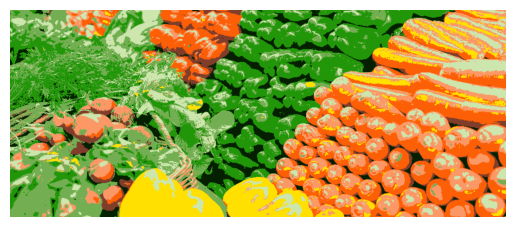

In [147]:
output = mean_shift(test_image_3)
output = (output - output.min()) / (output.max() - output.min())
plt.imshow(output)
plt.axis('off')  
plt.show()

In [166]:
luv_image = map_rgb_luv(test_image_4)

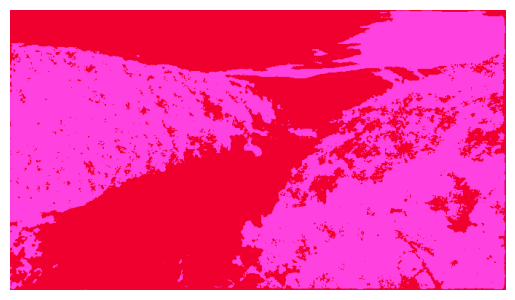

In [168]:
output = mean_shift(luv_image)
output = (output - output.min()) / (output.max() - output.min())
plt.imshow(output)
plt.axis('off')  
plt.show()

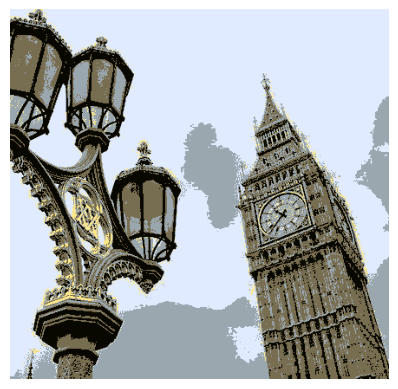

In [130]:
output = mean_shift(test_image_1)
output = (output - output.min()) / (output.max() - output.min())
plt.imshow(output)
plt.axis('off')  
plt.show()

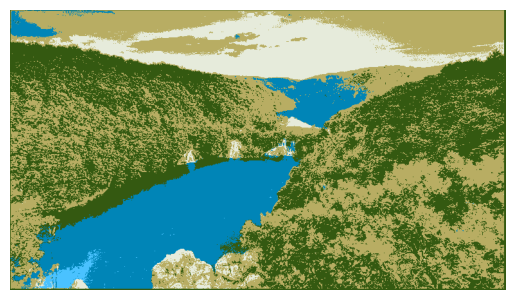

In [138]:
output = mean_shift(test_image_4)
output = (output - output.min()) / (output.max() - output.min())
plt.imshow(output)
plt.axis('off')  
plt.show()